In [1]:
!pip install scipy pandas scikit-learn

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

plt.rcParams["figure.figsize"] = (6, 4)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
OU_RAW_PATH = "/content/drive/MyDrive/ML_For_TimeSeries/ou_process_simulation.csv"
DOUBLEWELL_PATH = "/content/drive/MyDrive/ML_For_TimeSeries/DoubleWell_moments.csv"
CIR_PATH        = "/content/drive/MyDrive/ML_For_TimeSeries/cir_process_simulations.csv"
DT_OU = 0.01

In [4]:
def compute_ou_10_raw_moments_from_csv(path, dt=0.01, max_order=10):
    """
    Compute raw moments E[X^k] for k=1..max_order from OU raw sims.

    CSV format:
        col0 (constant, e.g. 0.5) | sim_1 | sim_2 | ... | sim_N
    """
    df = pd.read_csv(path, header=None)

    # drop constant column
    X = df.iloc[:, 1:].values   # shape [T, N_sims]

    T = X.shape[0]
    time = np.arange(T) * dt

    data = {"time": time}
    for k in range(1, max_order + 1):
        data[f"m{k}"] = (X ** k).mean(axis=1)

    moments_df = pd.DataFrame(data)
    return moments_df

# use it:
ou_df = compute_ou_10_raw_moments_from_csv(OU_RAW_PATH, dt=DT_OU)

In [5]:
def schatten_Lk_normalize(moment_df, moment_cols, moment_orders, train_frac=0.7, eps=1e-8):
    """
    Normalize each moment m_k(t) by its L_k norm over the train portion:
        ||m_k||_k = (sum_t |m_k(t)|^k)^(1/k)
    moment_cols: ["mean", "variance", "skewness", "kurtosis", ...]
    moment_orders: corresponding moment orders [1,2,3,4,...]
    """
    T = len(moment_df)
    T_train = int(train_frac * T)

    norms = {}
    normed = moment_df.copy()

    for col, k in zip(moment_cols, moment_orders):
        v = normed[col].values.astype(float)
        train_v = v[:T_train]
        Lk = np.power(np.sum(np.abs(train_v) ** k), 1.0 / k)
        if Lk < eps:
            Lk = 1.0
        norms[col] = Lk
        normed[col] = v / Lk

    return normed, norms

In [28]:
import matplotlib.pyplot as plt

def plot_moment_predictions(df_moments,
                            M_true,
                            preds_true,
                            T_train,
                            moment_cols,
                            model_name="Model",
                            dataset_name="Dataset",
                            num_moments_to_plot=3):
    """
    Plot true vs predicted trajectories for the first few moments
    on the test segment.

    df_moments : DataFrame with a 'time' column and moment columns
    M_true     : [T, K] array of true (unnormalized) moments
    preds_true : [L, K] array of model predictions for times T_train+1..T-1
    T_train    : index where training ends
    moment_cols: list of column names corresponding to columns in M_true
    """
    if preds_true.shape[0] == 0:
        print(f"[{model_name} | {dataset_name}] No predictions to plot (too short series).")
        return

    time = df_moments["time"].values
    T = len(time)
    L = preds_true.shape[0]

    # predicted i corresponds to time index T_train+1+i
    idx_pred = np.arange(T_train + 1, T_train + 1 + L)
    idx_pred = idx_pred[idx_pred < T]
    L_eff = len(idx_pred)

    if L_eff == 0:
        print(f"[{model_name} | {dataset_name}] No valid prediction indices after alignment.")
        return

    # we might truncate preds_true if needed
    preds_true = preds_true[:L_eff, :]

    # plot first few moments
    num_moments_to_plot = min(num_moments_to_plot, len(moment_cols))

    for j in range(num_moments_to_plot):
        col = moment_cols[j]

        plt.figure()
        plt.title(f"{dataset_name} – {model_name}: {col}")
        plt.plot(time[idx_pred],
                 M_true[idx_pred, j],
                 label="true")
        plt.plot(time[idx_pred],
                 preds_true[:, j],
                 "--",
                 label="predicted")
        plt.xlabel("time")
        plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [6]:
def fit_var2_ridge(M_norm, ridge_alpha=1e-2, train_frac=0.7):
    """
    M_norm: [T, k] normalized moments (no time column)
    Fits VAR(2) with Ridge on 1-step prediction using only the train segment.

    Returns:
        A   : [k, 2k] matrix (A1 | A2)
        T_train : index where train segment ends (in time)
    """
    T, k = M_norm.shape
    T_train = int(train_frac * T)

    X_train = []
    Y_train = []

    # 1-step mapping: m_{t+1} from [m_t, m_{t-1}]
    for t in range(1, T_train - 1):
        feat = np.concatenate([M_norm[t], M_norm[t - 1]])  # [2k]
        targ = M_norm[t + 1]                               # [k]
        X_train.append(feat)
        Y_train.append(targ)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    model = Ridge(alpha=ridge_alpha, fit_intercept=False)
    model.fit(X_train, Y_train)

    # A is model.coef_: [k, 2k]
    A = model.coef_
    return A, T_train


In [7]:
def recursive_forecast_var2(M_norm, A, T_train):
    """
    Recursive closed-loop forecast on the *test* segment.

    M_norm : [T, k] normalized moments
    A      : [k, 2k]
    T_train: index where training ends

    Returns:
        preds_norm: [T_test-1, k] normalized predictions for times
                    T_train+1 .. T-1
    """
    T, k = M_norm.shape
    T_test = T - T_train

    if T_test <= 1:
        return np.empty((0, k))

    preds = []

    # initial previous and current states
    m_prev = M_norm[T_train - 1]
    m_curr = M_norm[T_train]

    for t in range(T_train, T - 1):
        feat = np.concatenate([m_curr, m_prev])  # [2k]
        y_pred = A @ feat                        # [k]
        preds.append(y_pred)

        m_prev, m_curr = m_curr, y_pred

    return np.array(preds)  # [T_test - 1, k]


In [8]:
def compute_multi_horizon_metrics(M_true, preds, T_train, horizons=(1, 5, 10)):
    """
    M_true: [T, k] unnormalized true moments
    preds : [L, k] predictions for times T_train+1..T-1
            where L = T - T_train - 1
    T_train: split index
    Returns:
        DataFrame with MSE, RMSE, NRMSE per horizon.
    """
    T, k = M_true.shape
    L = preds.shape[0]   # = T - T_train - 1

    results = []

    for h in horizons:
        max_i = L - (h - 1)
        if max_i <= 0:
            continue

        Y_true = []
        Y_hat = []

        for i in range(max_i):
            t_target = T_train + 1 + i + (h - 1)
            if t_target >= T:
                break
            Y_true.append(M_true[t_target])
            Y_hat.append(preds[i])

        Y_true = np.array(Y_true)
        Y_hat = np.array(Y_hat)

        if len(Y_true) == 0:
            continue

        mse = ((Y_true - Y_hat) ** 2).mean()
        rmse = np.sqrt(mse)
        std_true = Y_true.std()
        nrmse = rmse / (std_true + 1e-8)

        results.append({"horizon": h, "MSE": mse, "RMSE": rmse, "NRMSE": nrmse})

    return pd.DataFrame(results)


In [37]:
def run_var_baseline(name, df_moments, train_frac=0.7):
    print(f"\n===== {name} =====")

    # All non-'time' columns are treated as moments (m1..m10)
    moment_cols = [c for c in df_moments.columns if c != "time"]
    moment_orders = list(range(1, len(moment_cols) + 1))

    # 1) normalize
    norm_df, norms = schatten_Lk_normalize(
        df_moments,
        moment_cols=moment_cols,
        moment_orders=moment_orders,
        train_frac=train_frac
    )

    # explicitly cast to float (robust)
    M_norm = norm_df[moment_cols].astype(float).values
    M_true = df_moments[moment_cols].astype(float).values

    # 2) fit VAR(2)+Ridge
    A, T_train = fit_var2_ridge(M_norm, ridge_alpha=1e-2, train_frac=train_frac)

    # 3) recursive forecast on normalized
    preds_norm = recursive_forecast_var2(M_norm, A, T_train)

    # 4) unnormalize predictions
    preds_true = np.zeros_like(preds_norm)
    for j, col in enumerate(moment_cols):
        preds_true[:, j] = preds_norm[:, j] * norms[col]

    # 5) metrics on unnormalized moments
    metrics_df = compute_multi_horizon_metrics(
        M_true,
        preds_true,
        T_train,
        horizons=(1, 5, 10)
    )
    print(metrics_df)

    # 6) plots (first few moments)
    if "time" in df_moments.columns:
        plot_moment_predictions(df_moments,
                                M_true,
                                preds_true,
                                T_train,
                                moment_cols,
                                model_name="VAR(2)",
                                dataset_name=name,
                                num_moments_to_plot=3)

    return metrics_df


In [10]:
def fit_poly_baseline(M_norm, degree=2, ridge_alpha=1e-2, train_frac=0.7):
    """
    Polynomial autoregressive baseline:
        m_{t+1} = W * phi(m_t),
    where phi are polynomial features up to 'degree'.
    """
    T, k = M_norm.shape
    T_train = int(train_frac * T)

    X_train_raw = M_norm[:T_train-1]   # m_t
    Y_train     = M_norm[1:T_train]    # m_{t+1}

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train = poly.fit_transform(X_train_raw)

    model = Ridge(alpha=ridge_alpha, fit_intercept=False)
    model.fit(X_train, Y_train)

    return model, poly, T_train

In [11]:
def recursive_forecast_poly(M_norm, model, poly, T_train):
    """
    Closed-loop m_{t+1} = model(phi(m_t)) on the test segment.
    Returns normalized predictions.
    """
    T, k = M_norm.shape
    T_test = T - T_train
    if T_test <= 1:
        return np.empty((0, k))

    preds = []
    m_curr = M_norm[T_train - 1]  # last train point

    for t in range(T_train - 1, T - 1):
        X_feat = poly.transform(m_curr.reshape(1, -1))
        y_pred = model.predict(X_feat)[0]
        preds.append(y_pred)
        m_curr = y_pred

    return np.array(preds)


In [30]:
def run_poly_baseline(name, df_moments, train_frac=0.7, degree=2):
    print(f"\n===== Polynomial baseline: {name} =====")

    moment_cols = [c for c in df_moments.columns if c != "time"]
    moment_orders = list(range(1, len(moment_cols) + 1))

    # 1) normalize
    norm_df, norms = schatten_Lk_normalize(
        df_moments,
        moment_cols=moment_cols,
        moment_orders=moment_orders,
        train_frac=train_frac
    )

    M_norm = norm_df[moment_cols].astype(float).values
    M_true = df_moments[moment_cols].astype(float).values

    # 2) fit polynomial AR model
    model, poly, T_train = fit_poly_baseline(
        M_norm,
        degree=degree,
        ridge_alpha=1e-2,
        train_frac=train_frac
    )

    # 3) recursive forecast (normalized)
    preds_norm = recursive_forecast_poly(M_norm, model, poly, T_train)

    # 4) unnormalize
    preds_true = np.zeros_like(preds_norm)
    for j, col in enumerate(moment_cols):
        preds_true[:, j] = preds_norm[:, j] * norms[col]

    # 5) metrics
    metrics_df = compute_multi_horizon_metrics(
        M_true,
        preds_true,
        T_train,
        horizons=(1, 5, 10)
    )
    print(metrics_df)

    # 6) plots
    if "time" in df_moments.columns:
        plot_moment_predictions(df_moments,
                                M_true,
                                preds_true,
                                T_train,
                                moment_cols,
                                model_name=f"Poly(deg={degree})",
                                dataset_name=name,
                                num_moments_to_plot=3)

    return metrics_df


In [13]:
def add_time_column(df, dt=0.01):
    """Put 'time' as the FIRST column: time = dt * row_index."""
    df = df.copy()
    T = len(df)
    time = np.arange(T) * dt
    df.insert(0, "time", time)
    return df

In [24]:
def clean_moment_df(df, dt=0.01, add_time_if_missing=True):
    """
    Ensure:
      - 'time' column exists (optional)
      - all other columns are numeric (float)
      - rows with NaNs in moment columns are dropped
    """
    df = df.copy()

    # Add time if missing
    if add_time_if_missing and "time" not in df.columns:
        T = len(df)
        time = np.arange(T) * dt
        df.insert(0, "time", time)

    # Identify moment columns: everything except 'time'
    moment_cols = [c for c in df.columns if c != "time"]

    # Convert to numeric, coercing bad strings to NaN
    df[moment_cols] = df[moment_cols].apply(pd.to_numeric, errors="coerce")

    # Drop rows that have NaN in any moment column
    df = df.dropna(subset=moment_cols).reset_index(drop=True)

    return df


In [18]:
# --- Double-well: 10 moments ---
dw_raw = pd.read_csv(DOUBLEWELL_PATH, header=None)
dw_raw = dw_raw.iloc[1:].reset_index(drop=True)  # drop artifact row
dw_raw = dw_raw.iloc[:, :10]  # keep first 10 moment columns
dw_raw.columns = [f"m{k}" for k in range(1, 11)]
dw_df = add_time_column(dw_raw, dt=0.01)

# --- CIR: 10 moments (drop bad first row) ---
cir_raw = pd.read_csv(CIR_PATH, header=None)
cir_raw = cir_raw.iloc[1:].reset_index(drop=True)  # drop artifact row
cir_raw = cir_raw.iloc[:, :10]                     # first 10 moments
cir_raw.columns = [f"m{k}" for k in range(1, 11)]
cir_df = add_time_column(cir_raw, dt=0.01)
ou_df = compute_ou_10_raw_moments_from_csv(OU_RAW_PATH, dt=DT_OU, max_order=10)

print(ou_df.head())
print(dw_df.head())
print(cir_df.head())

   time          m1             m2            m3            m4            m5  \
0  0.00  500.500000  333833.500000  2.505002e+08  2.005003e+11  1.671671e+14   
1  0.01   -0.075406       0.058162 -9.476724e-03  9.108523e-03 -2.205882e-03   
2  0.02   -0.208831       0.182775 -1.008891e-01  8.615792e-02 -6.814922e-02   
3  0.03    0.148473       0.065863  2.171204e-02  1.051026e-02  4.530621e-03   
4  0.04    0.093399       0.106498  8.938038e-03  2.281989e-02  8.447602e-04   

             m6            m7            m8            m9           m10  
0  1.433576e+17  1.255006e+20  1.116118e+23  1.005007e+26  9.140992e+28  
1  1.973839e-03 -6.331327e-04  5.025219e-04 -1.969720e-04  1.421455e-04  
2  6.213208e-02 -5.692150e-02  5.473312e-02 -5.330172e-02  5.291871e-02  
3  2.341422e-03  1.171043e-03  6.392378e-04  3.485364e-04  1.984786e-04  
4  6.187786e-03 -8.322931e-05  1.891840e-03 -1.204278e-04  6.229022e-04  
   time                       m1                     m2  \
0  0.00   -5.629

In [25]:
ou_df  = clean_moment_df(ou_df,  dt=DT_OU, add_time_if_missing=("time" not in ou_df.columns))
dw_df  = clean_moment_df(dw_df,  dt=0.01,  add_time_if_missing=("time" not in dw_df.columns))
cir_df = clean_moment_df(cir_df, dt=0.01,  add_time_if_missing=("time" not in cir_df.columns))

print("OU columns: ", ou_df.columns)
print("DW columns: ", dw_df.columns)
print("CIR columns:", cir_df.columns)

OU columns:  Index(['time', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10'], dtype='object')
DW columns:  Index(['time', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10'], dtype='object')
CIR columns: Index(['time', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10'], dtype='object')



===== OU (VAR) =====
   horizon       MSE      RMSE     NRMSE
0        1  0.001993  0.044639  1.033010
1        5  0.002149  0.046360  1.038861
2       10  0.001782  0.042215  1.026476


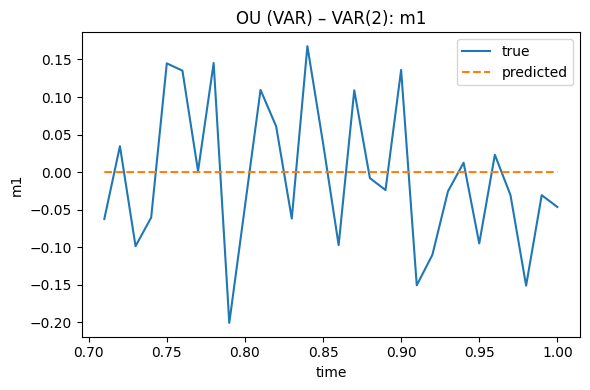

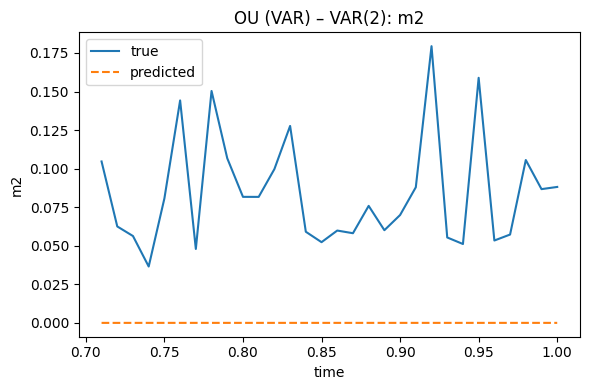

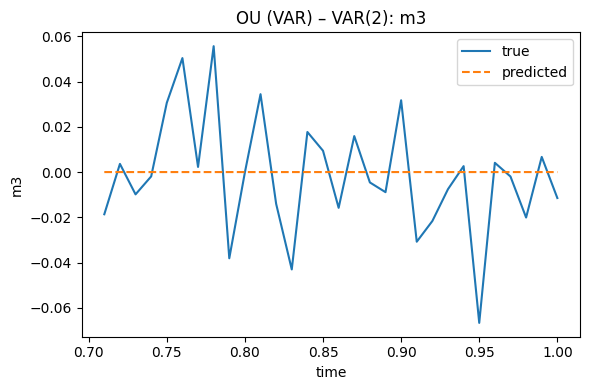


===== Double-well (VAR) =====
   horizon           MSE      RMSE     NRMSE
0        1  1.138526e-08  0.000107  0.137583
1        5  1.133270e-08  0.000106  0.137260
2       10  1.126527e-08  0.000106  0.136842


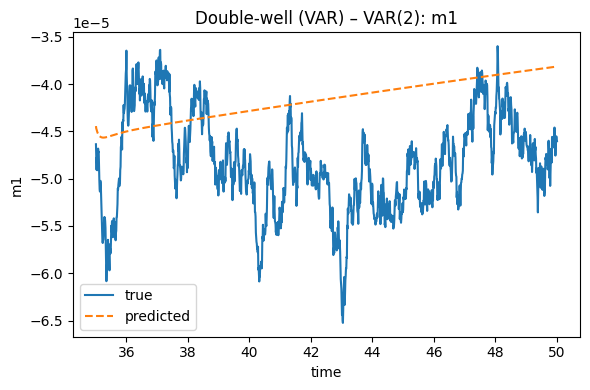

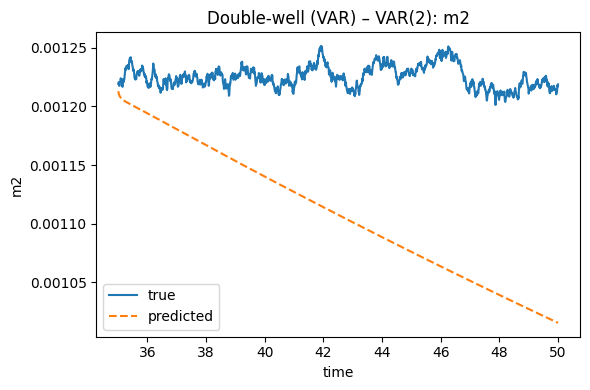

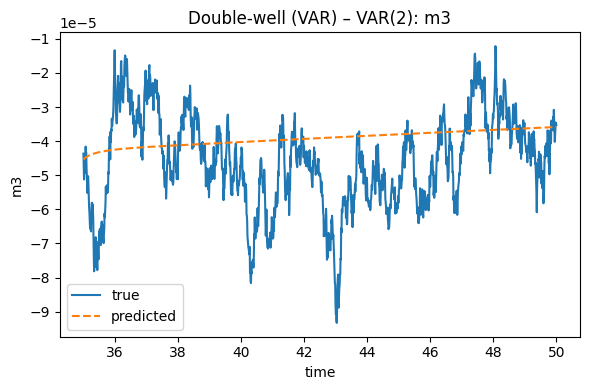


===== CIR (VAR) =====
   horizon       MSE      RMSE     NRMSE
0        1  0.000030  0.005510  0.239932
1        5  0.000029  0.005418  0.235825
2       10  0.000028  0.005305  0.230717


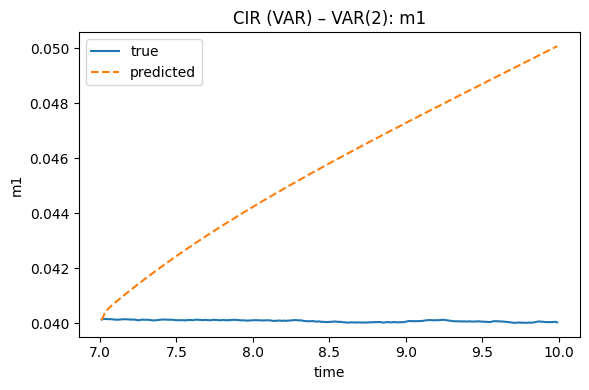

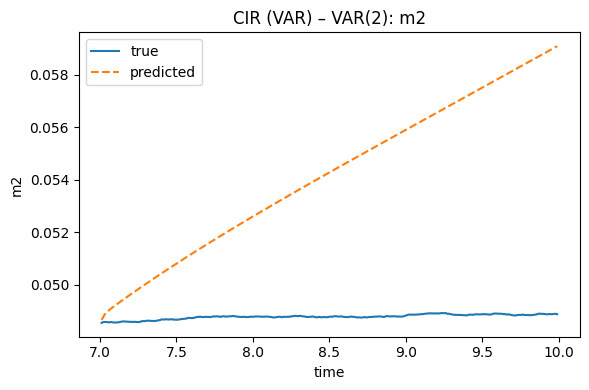

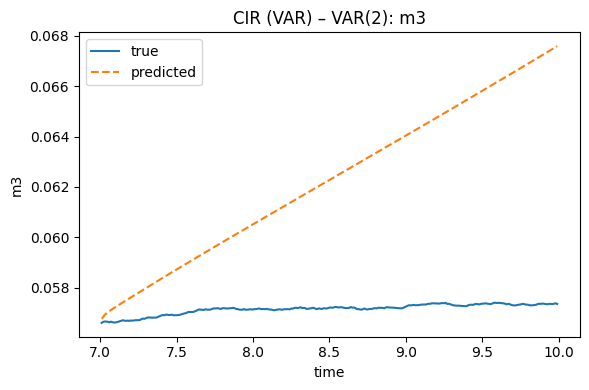


===== Polynomial baseline: OU (Poly) =====
   horizon       MSE      RMSE     NRMSE
0        1  0.001993  0.044639  1.033008
1        5  0.002149  0.046359  1.038852
2       10  0.001782  0.042214  1.026471


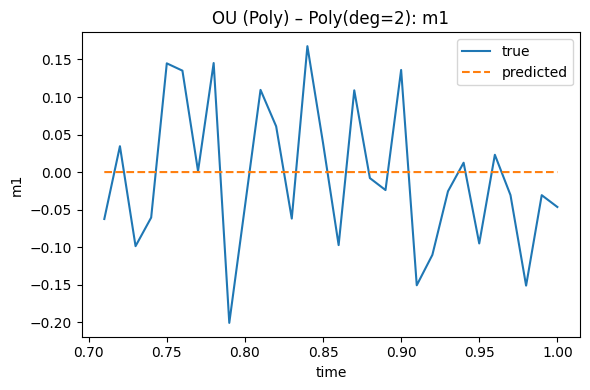

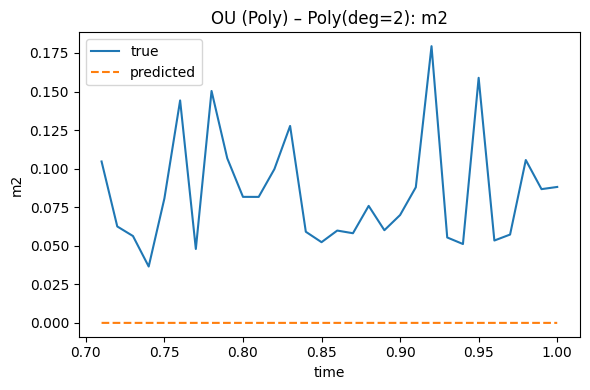

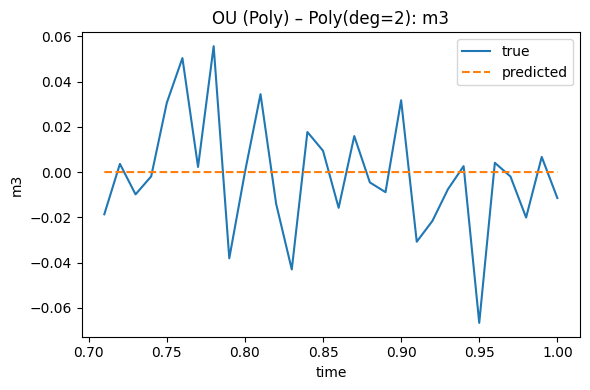


===== Polynomial baseline: Double-well (Poly) =====
   horizon           MSE      RMSE     NRMSE
0        1  2.242809e-08  0.000150  0.193104
1        5  2.231680e-08  0.000149  0.192617
2       10  2.217731e-08  0.000149  0.192001


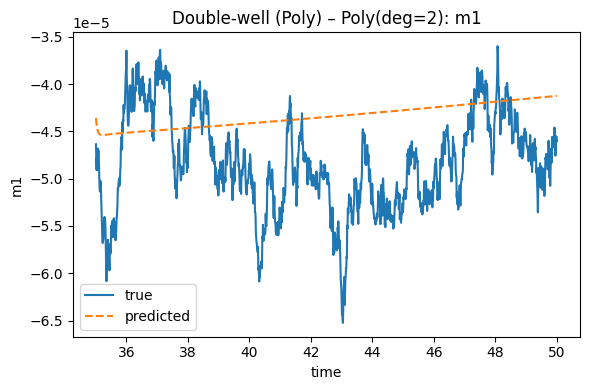

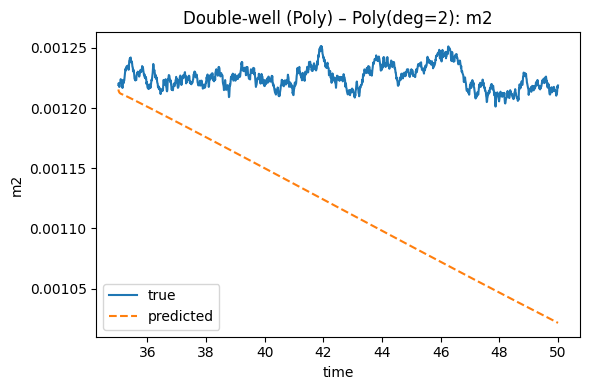

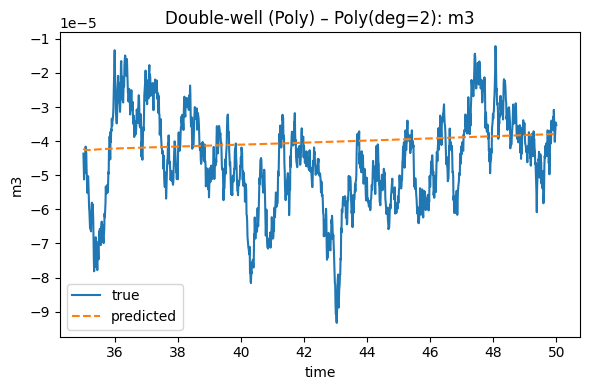


===== Polynomial baseline: CIR (Poly) =====
   horizon       MSE      RMSE     NRMSE
0        1  0.000052  0.007196  0.313347
1        5  0.000052  0.007215  0.314058
2       10  0.000052  0.007236  0.314737


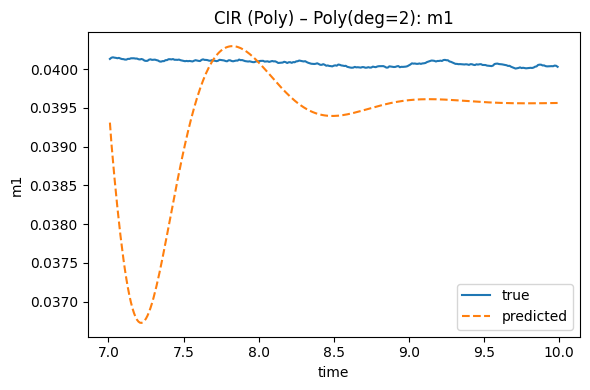

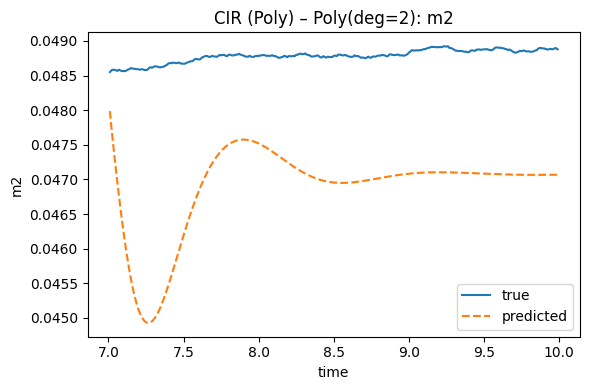

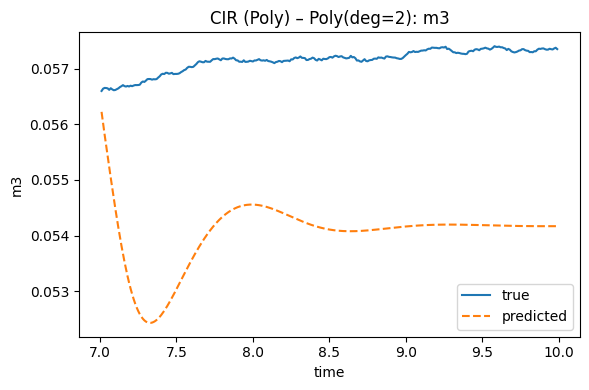


===== Summary of Baseline Results =====
    horizon           MSE      RMSE     NRMSE model
0         1  1.992672e-03  0.044639  1.033010   VAR
1         5  2.149224e-03  0.046360  1.038861   VAR
2        10  1.782070e-03  0.042215  1.026476   VAR
3         1  1.138526e-08  0.000107  0.137583   VAR
4         5  1.133270e-08  0.000106  0.137260   VAR
5        10  1.126527e-08  0.000106  0.136842   VAR
6         1  3.035770e-05  0.005510  0.239932   VAR
7         5  2.935381e-05  0.005418  0.235825   VAR
8        10  2.813819e-05  0.005305  0.230717   VAR
9         1  1.992664e-03  0.044639  1.033008  Poly
10        5  2.149185e-03  0.046359  1.038852  Poly
11       10  1.782054e-03  0.042214  1.026471  Poly
12        1  2.242809e-08  0.000150  0.193104  Poly
13        5  2.231680e-08  0.000149  0.192617  Poly
14       10  2.217731e-08  0.000149  0.192001  Poly
15        1  5.177775e-05  0.007196  0.313347  Poly
16        5  5.206017e-05  0.007215  0.314058  Poly
17       10  5.236384e-

In [38]:
# --- Run VAR baseline on 10-moment data ---
metrics_ou_var  = run_var_baseline("OU (VAR)", ou_df)
metrics_dw_var  = run_var_baseline("Double-well (VAR)", dw_df)
metrics_cir_var = run_var_baseline("CIR (VAR)", cir_df)

# --- Run Polynomial baseline on 10-moment data ---
metrics_ou_poly  = run_poly_baseline("OU (Poly)", ou_df, degree=2)
metrics_dw_poly  = run_poly_baseline("Double-well (Poly)", dw_df, degree=2)
metrics_cir_poly = run_poly_baseline("CIR (Poly)", cir_df, degree=2)

# --- Create summary table ---
summary = pd.concat([
    metrics_ou_var.assign(model="VAR"),
    metrics_dw_var.assign(model="VAR"),
    metrics_cir_var.assign(model="VAR"),
    metrics_ou_poly.assign(model="Poly"),
    metrics_dw_poly.assign(model="Poly"),
    metrics_cir_poly.assign(model="Poly"),
])

print("\n===== Summary of Baseline Results =====")
print(summary.reset_index(drop=True))
